# a notebook to figure out some plotting stuff
- for example, a strikezone view of the pitches when they cross the plate
- 3d trails if I can figure that out ( I think there are polynomials in the baseball savant endpoint here: https://baseballsavant.mlb.com/gf?game_pk=) 

In [1]:
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from pybaseball import statcast_batter, spraychart, plot_stadium

import requests as re
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import patchworklib as pw

from src.baseball import *


No module named 'seaborn'


<Figure size 100x100 with 0 Axes>

In [43]:
pd.read_csv("data/tto.csv")

,home_run,strikeout,walk,events,name_first,name_last,key_mlbam,run_date,has_been_posted,posted_time


In [41]:
# this defaults to yesterday
end_dt = '2023-04-05'
# remember this will be utc 
#end_dt = str(datetime.date.today() + datetime.timedelta(days=-1))

df = statcast(start_dt=end_dt, end_dt=end_dt)

print(df.shape)

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.19s/it]

(3520, 92)


In [42]:
df.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1826,SL,2023-04-05,78.2,-3.27,4.05,"Thompson, Ryan",657041,657044,field_out,hit_into_play,...,7,7,2,2,7,Standard,Standard,77,-0.004,-0.349
1871,SI,2023-04-05,92.3,-3.51,4.18,"Thompson, Ryan",657041,657044,NaN,foul,...,7,7,2,2,7,Standard,Standard,268,0.0,-0.137
1918,SI,2023-04-05,92.0,-3.35,4.08,"Thompson, Ryan",657041,657044,NaN,called_strike,...,7,7,2,2,7,Standard,Standard,266,0.0,-0.09
2001,SL,2023-04-05,79.2,-3.47,4.03,"Thompson, Ryan",657041,657044,NaN,ball,...,7,7,2,2,7,Standard,Standard,73,0.0,0.08
2046,SI,2023-04-05,91.8,-3.43,4.05,"Thompson, Ryan",682928,657044,field_out,hit_into_play,...,7,7,2,2,7,Standard,Standard,270,-0.011,-0.449
2107,SL,2023-04-05,78.8,-3.42,4.03,"Thompson, Ryan",682928,657044,NaN,ball,...,7,7,2,2,7,Standard,Standard,81,0.0,0.012
2124,SL,2023-04-05,78.8,-3.56,4.0,"Thompson, Ryan",682928,657044,NaN,swinging_strike,...,7,7,2,2,7,Standard,Standard,80,0.0,0.031
2194,SI,2023-04-05,90.2,-3.44,4.03,"Thompson, Ryan",645302,657044,walk,ball,...,7,7,2,2,7,Standard,Standard,264,0.009,0.34
2278,SI,2023-04-05,89.9,-3.45,3.95,"Thompson, Ryan",645302,657044,NaN,foul,...,7,7,2,2,7,Standard,Standard,276,0.0,0.0
2326,SI,2023-04-05,90.2,-3.55,4.01,"Thompson, Ryan",645302,657044,NaN,called_strike,...,7,7,2,2,7,Standard,Standard,267,0.0,-0.204


In [4]:
df.pitcher.value_counts()

664285    103
645261    100
622491     99
676664     98
608566     95
         ... 
666374      5
594580      5
669796      4
669276      3
660593      3
Name: pitcher, Length: 116, dtype: Int64

In [5]:
a_pitch = df.loc[1]

In [6]:
a_pitch

pitch_type                                CH
game_date                2023-04-04 00:00:00
release_speed                           91.9
release_pos_x                           0.46
release_pos_z                           6.22
                                ...         
if_fielding_alignment               Standard
of_fielding_alignment               Standard
spin_axis                                134
delta_home_win_exp                       0.0
delta_run_exp                         -0.027
Name: 1, Length: 92, dtype: object

In [7]:
a_pitch.game_pk

718705

In [8]:
pitch_abbreviation_to_name = {
    "FF" : "4-Seam Fastball",
    "CU" : "Curveball",
    "CH" : "Changeup",
    "FC" : "Cutter",
    "EP" : "Eephus",
    "FO" : "Forkball",
    "KN" : "Knuckleball",
    "KC" : "Knuckle-curve",
    "SC" : "Screwball",
    "SI" : "Sinker",
    "SL" : "Slider",
    "FS" : "Splitter",
    "FT" : "2-Seam Fastball",
    "ST" : "Sweeper",
    "SV" : "Slurve"
}

In [9]:
# Do this again, but for all pitches

all_pitches = df[df.pitcher == 664285]
# here is the game that he pitched in https://www.youtube.com/watch?v=r5-DFUnWevY

In [10]:
all_pitches.pitch_type.value_counts()

SI    52
CH    23
CU    23
FC     5
Name: pitch_type, dtype: int64

In [11]:
all_pitches.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

## Quick things to make this better
- turn into a function
- different colors for different pitch types
- draw a plate?
- markers that show speed and type
- maybe movement with like a empty circle, vector, filled circle


maybe make it infer which kind of plot to make?

In [12]:
def plot_strike_zone(pitch_df: pd.DataFrame, title: str = '', colorby: str = 'pitch_type', annotation: str = None, axis = None) -> None:
    """
    Produces a pitches overlaid on a strike zone using statcast data
    
    Args:
        pitch_df: (pandas.DataFrame)
            StatCast pandas.DataFrame of StatCast batter data
        title: (str), default = ''
            Optional: Title of plot
        colorby: (str), default = 'pitch_type'
            Optional: Which category to color the mark with. 'pitch_type','pitcher', 'description' or a column within data
        legend_title: (str), default = based on colorby
            Optional: Title for the legend
        width: (int), default = 500
            Optional: Width of plot (not counting the legend)
        height: (int), default = 500
            Optional: Height of plot
    Returns:
        A matplotlib.axes.Axes object that was used to generate the pitches overlaid on the strike zone
    """
    
    
    # some things to auto adjust formatting
    # make the markers really visible when fewer pitches
    alpha_markers = min(0.8, 0.5 + 1 / pitch_df.shape[0])
    alpha_text = alpha_markers + 0.2
    
    # define Matplotlib figure and axis
    if axis is None:
        fig, axis = plt.subplots()

    # add home plate to plot 
    home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]
    plate = Polygon(home_plate_coords,
                edgecolor = 'darkgray',
                facecolor = 'lightgray',
                lw = 2)
    axis.add_patch(plate)
    
    # add strike zone to plot. technically this can vary by batter
    # ignore that for now
    axis.add_patch(Rectangle((-0.71, 1.5), 2*0.71, 2,
                 edgecolor = 'lightgray',
                 fill=False,
                 lw=3))
    
    legend_title = ""
    color_label = ""
    
    # to avoid the SettingWithCopyWarning error
    sub_data = pitch_df.copy().reset_index(drop=True)
    
    if colorby == 'pitch_type':
        color_label = 'pitch_type'
        
        if not legend_title:
            legend_title = 'Pitch Type'
            
    elif colorby == 'description':
        values = sub_data.loc[:, 'description'].str.replace('_', ' ').str.title()
        sub_data.loc[:, 'desc'] = values
        color_label = 'desc'
        
        if not legend_title:
            legend_title = 'Pitch Description'
    elif colorby == 'pitcher':
        color_label = 'player_name'
        
        if not legend_title:
            legend_title = 'Pitcher'
            
    elif colorby == "events":
        # only things where something happened
        sub_data = sub_data[sub_data['events'].notna()]
        sub_data['event'] = sub_data['events'].str.replace('_', ' ').str.title()
        color_label = 'event'
        
        if not legend_title:
            legend_title = 'Outcome'
    
    else:
        color_label = colorby
        if not legend_title:
            legend_title = colorby
        
    scatters = []
    
    for color in sub_data[color_label].unique():
        color_sub_data = sub_data[sub_data[color_label] == color]
        scatters.append(axis.scatter(
            color_sub_data["plate_x"],
            color_sub_data['plate_z'],
            s = 10**2,
            label = pitch_abbreviation_to_name[color] if color_label == 'pitch_type' else color,
            alpha = alpha_markers
        ))

        
        # add an annotation at the center of the marker
        if annotation:
            for i, pitch_coord in zip(color_sub_data.index, zip(color_sub_data["plate_x"], color_sub_data['plate_z'])):
                label_formatted = color_sub_data.loc[i, annotation]
                label_formatted = label_formatted if not pd.isna(label_formatted) else ""
                
                if annotation in ["release_speed", "effective_speed", "launch_speed"] and label_formatted != "":
                    label_formatted = "{:.0f}".format(label_formatted)
                
                axis.annotate(label_formatted,
                            pitch_coord,
                            size = 7,
                            ha = 'center',
                            va = 'center',
                            alpha = alpha_text)

    axis.set_xlim(-4, 4)
    axis.set_ylim(-1.5, 7)
    
    axis.axis('off')

    axis.legend(handles=scatters, title=legend_title, bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.title(title)

    #plt.show()
    
    #return ax
    
    

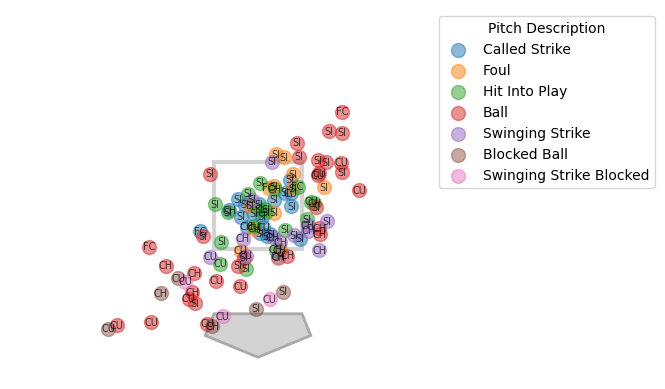

In [13]:
all_pitches = df[df["pitcher"] == 664285]

plot_strike_zone(all_pitches, colorby = 'description', annotation = "pitch_type")

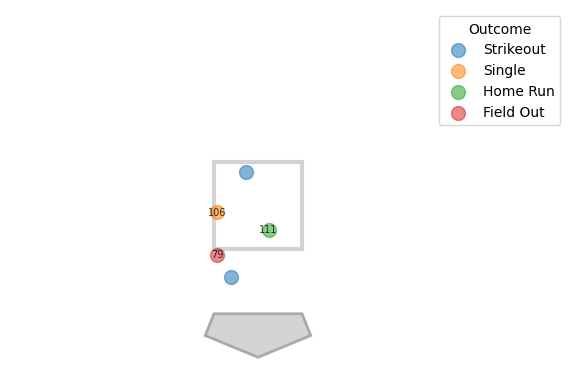

In [14]:
plot_strike_zone(df.iloc[:20], colorby = 'events', annotation = "launch_speed")

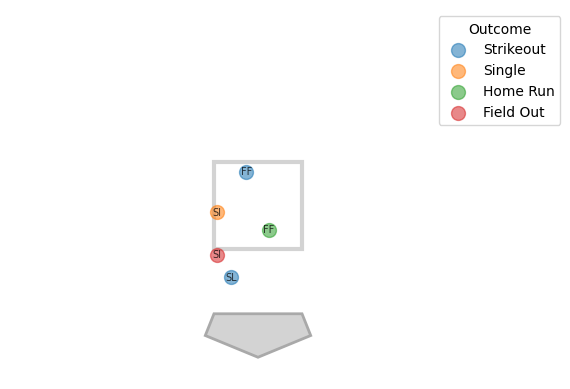

In [15]:
plot_strike_zone(df.iloc[:20], colorby = 'events', annotation = "pitch_type")

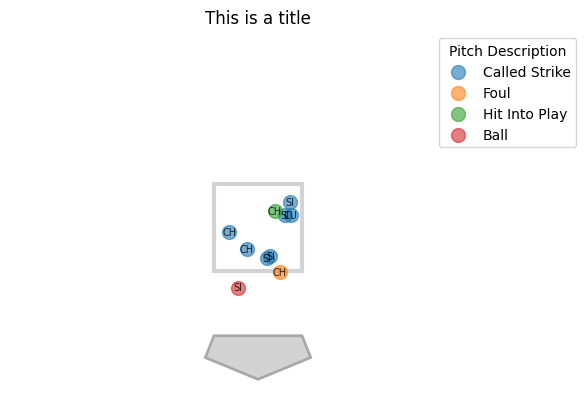

In [16]:
plot_strike_zone(all_pitches.iloc[:10], title = "This is a title", colorby = 'description', annotation = "pitch_type")

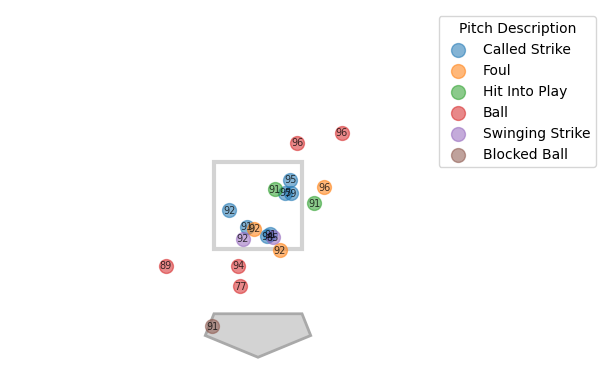

In [17]:
plot_strike_zone(all_pitches.iloc[:20], colorby = 'description', annotation = "release_speed")

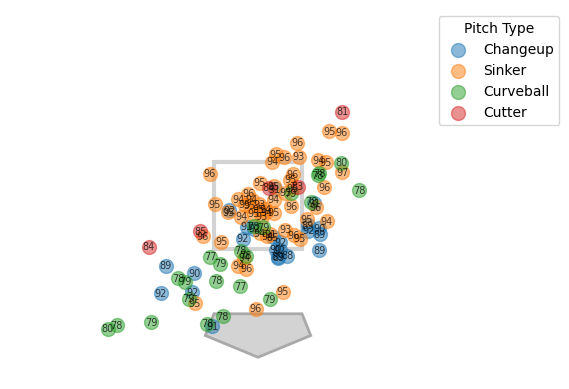

In [18]:
plot_strike_zone(all_pitches, colorby = 'pitch_type', annotation = "release_speed")

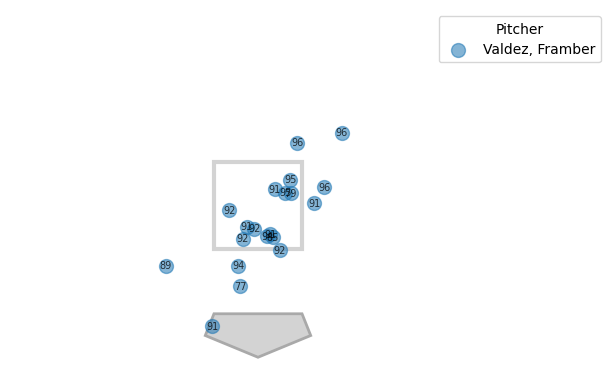

In [19]:
plot_strike_zone(all_pitches.iloc[:20], colorby = 'pitcher', annotation = "release_speed")

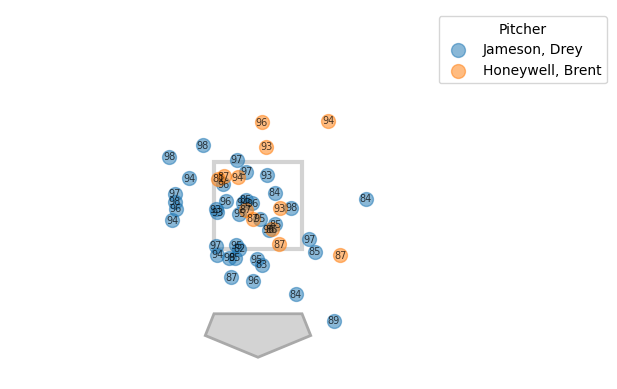

In [20]:
plot_strike_zone(df.iloc[:50], colorby = 'pitcher', annotation = "release_speed")

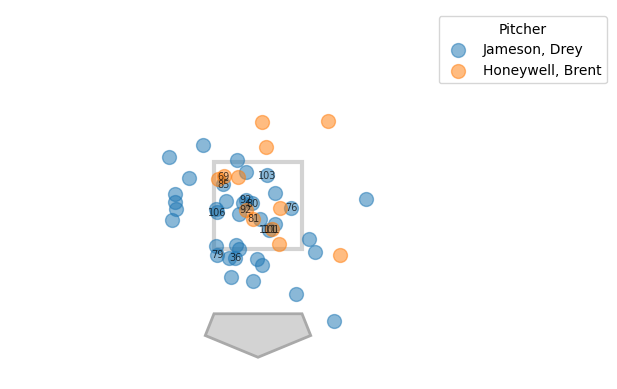

In [21]:
plot_strike_zone(df.iloc[:50], colorby = 'pitcher', annotation = "launch_speed")

## figure out how to put this side by side

In [22]:
# I think I need to add an optional axis argument in the spraychart fucntion so I can pass in as a subgraph

# how to preserve the aspect ratio?
# I think this is what I need
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/mosaic.html

In [23]:
def spraychart1(data: pd.DataFrame, team_stadium: str, title: str = '', tooltips = None,  # pylint: disable=too-many-arguments
               size: int = 100, colorby: str = 'events', legend_title: str = '', width: int = 500,
               height: int = 500, axis = None):
    """
    Produces a spraychart using statcast data overlayed on specified stadium
    
    Args:
        data: (pandas.DataFrame)
            StatCast pandas.DataFrame of StatCast batter data
        team_stadium: (str)
            Team whose stadium the hits will be overlaid on
        title: (str), default = ''
            Optional: Title of plot
        tooltips: (List[str]), default = None
            Optional: List of variables in data to include as tooltips (Deprecated)
        size: (int), default = 100
            Optional: Size of hit circles on plot
        colorby: (str), default = 'events'
            Optional: Which category to color the mark with. 'events','player', or a column within data
        legend_title: (str), default = based on colorby
            Optional: Title for the legend
        width: (int), default = 500
            Optional: Width of plot (not counting the legend)
        height: (int), default = 500
            Optional: Height of plot
    Returns:
        A matplotlib.axes.Axes object that was used to generate the stadium render and the spraychart
    """

    # pull stadium plot to overlay hits on
    base = plot_stadium(team_stadium, title, width-50, height, axis=axis)

    # only plot pitches where something happened
    sub_data = data.copy().reset_index(drop=True)
    sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]
    if colorby == 'events':
        sub_data['event'] = sub_data['events'].str.replace('_', ' ').str.title()
        color_label = 'event'
        if not legend_title:
            legend_title = 'Outcome'
    elif colorby == 'player':
        color_label = 'player_name'
        if not legend_title:
            legend_title = 'Player'
    else:
        color_label = colorby
        if not legend_title:
            legend_title = colorby

    # scatter plot of hits
    scatters = []
    for color in sub_data[color_label].unique():
        color_sub_data = sub_data[sub_data[color_label] == color]
        scatters.append(base.scatter(
            color_sub_data["hc_x"], color_sub_data['hc_y'].mul(-1), size, label=color, alpha=0.5
        ))

    if tooltips:
        warnings.warn(
            "Tooltips are disabled in the pyplot version of spraychart and will be removed in the future",
            category=DeprecationWarning
        )

    plt.legend(handles=scatters, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

    #plt.draw()

    #plt.show()

    #return base

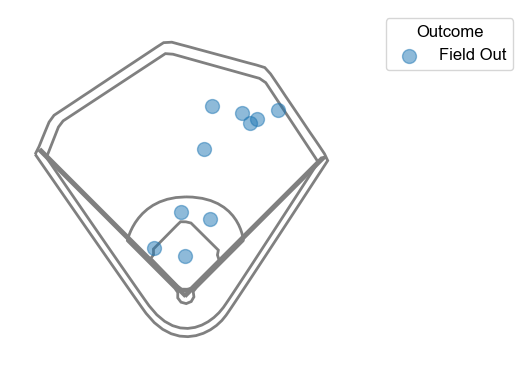

In [46]:
spray_ax = spraychart(df.iloc[:50], "orioles", height = 400, width=400)

In [49]:
ax1 = pw.Brick(figsize=(3,2))
ax2 = pw.Brick(figsize=(1,2))

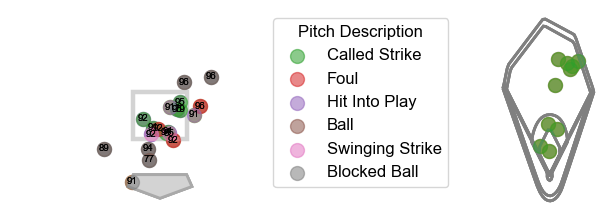

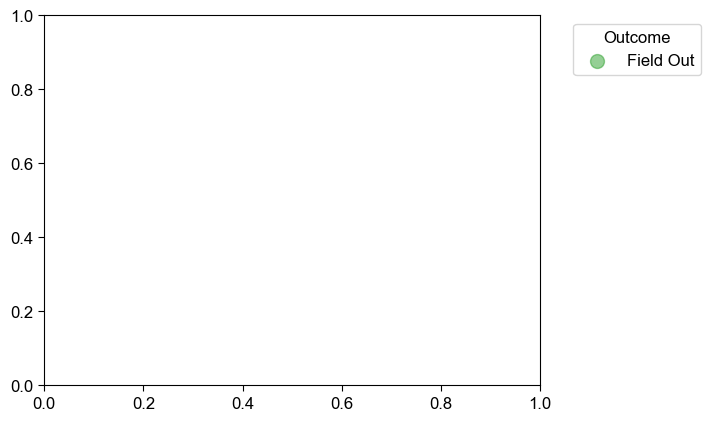

In [52]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12.8, 4.8))
plot_strike_zone(all_pitches.iloc[:20], colorby = 'description', annotation = "release_speed", axis = ax1)
#ax2.axis("off")

spraychart1(df.iloc[:50], "orioles", axis = ax2)


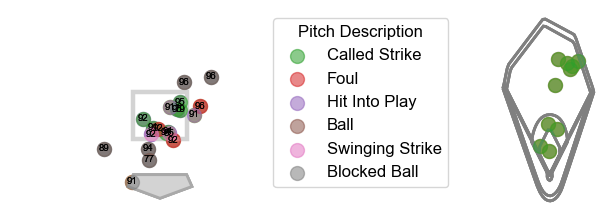

In [53]:
(ax1|ax2).savefig()

### Make a wrapper for the headshot getter

In [67]:
def get_player_headshot(mlbam_id, size = 200, file_path = "data/headshots/", file_name = None):
    
    base_img_url = "https://img.mlbstatic.com/mlb-photos/image/upload/w_{size},q_200/v1/people/{mlbam_id}/headshot/silo/current".format(size = size, mlbam_id = mlbam_id)
    
    print(base_img_url)
    
    img_resp = re.get(base_img_url)
    
    if img_resp.status_code != 200:
        print(img_resp.status_code)
        
        return -1
    else:
        os.makedirs(file_path, exist_ok=True)
        
        if file_name is None:
            file_name = str(mlbam_id) + ".png"
            
            
        with open(file_path + file_name, 'wb') as f:
            f.write(img_resp.content)
    

In [35]:
get_player_headshot(664284)

https://img.mlbstatic.com/mlb-photos/image/upload/w_200,q_200/v1/people/664284/headshot/silo/current


https://img.mlbstatic.com/mlb-photos/image/upload/w_200,q_200/v1/people/664285/headshot/silo/current


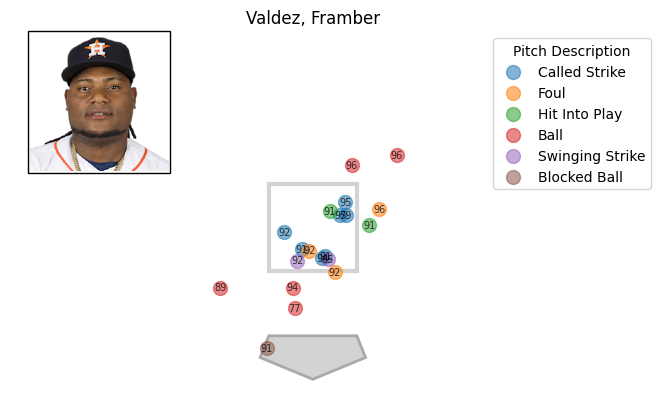

In [44]:
fig, ax = plt.subplots()

# IDK what this does tbh
xy = (1.05, 1)

player_id = all_pitches.pitcher[0]

get_player_headshot(player_id)

im = plt.imread("data/headshots/{}.png".format(player_id))

plot_strike_zone(all_pitches.iloc[:20], colorby = 'description', annotation = "release_speed", axis = ax, title=all_pitches.player_name[0])

imagebox = OffsetImage(im, zoom=0.5)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, xy,
                    xybox=(.15, 0.75),
                    xycoords='subfigure fraction',
                    boxcoords="subfigure fraction",
                    pad=0.1)

ax.add_artist(ab)

plt.show()

### Make a visualization with the strikezone

In [28]:
# THIS WILL ONLY WORK FOR THE FIRST PERSON! 

def make_tto_strikezone_plot(actual_row, tto_events):
    
    batter_df = tto_events[tto_events["batter"] == actual_row["key_mlbam"]]
    batter_name = actual_row.name_first.capitalize() + " " + actual_row.name_last.capitalize()
    
    fig, ax = plt.subplots()

    # IDK what this does tbh
    xy = (1.05, 1)

    player_id = batter_df.batter.iloc[0]

    get_player_headshot(player_id)

    im = plt.imread("data/headshots/{}.png".format(player_id))

    plot_strike_zone(batter_df, colorby = 'events', annotation = "pitch_type", axis = ax, title=batter_name)

    imagebox = OffsetImage(im, zoom=0.5)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, xy,
                        xybox=(.15, 0.75),
                        xycoords='subfigure fraction',
                        boxcoords="subfigure fraction",
                        pad=0.1)

    ax.add_artist(ab)

    plt.show()

In [24]:
only_three_outcomes, tto_events = get_three_true_outcomes(start_dt="2023-04-01", end_dt="2023-04-01", write_to_csv=False)

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.81s/it]


In [25]:
only_three_outcomes

,home_run,strikeout,walk,events,name_first,name_last,key_mlbam,run_date,has_been_posted,posted_time
0,2,1,1,4,matt,olson,621566,2023-04-01,False,None


In [26]:
only_three_outcomes

,home_run,strikeout,walk,events,name_first,name_last,key_mlbam,run_date,has_been_posted,posted_time
0,2,1,1,4,matt,olson,621566,2023-04-01,False,None


https://img.mlbstatic.com/mlb-photos/image/upload/w_200,q_200/v1/people/621566/headshot/silo/current


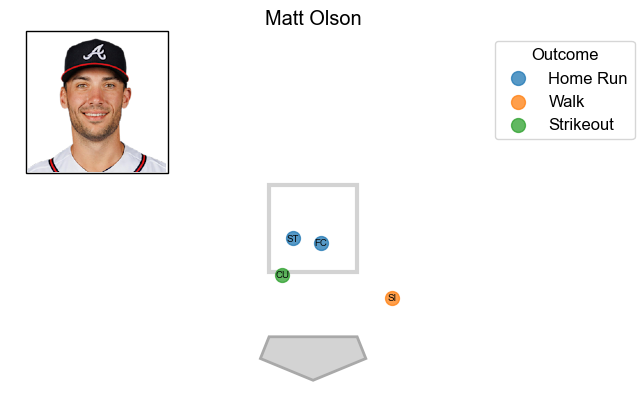

In [29]:
make_tto_strikezone_plot(get_next_unposted_row(only_three_outcomes), tto_events)